Imports

In [1]:
import feed_forward
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import geoopt
from time import time
from torchvision import datasets, transforms
import helper
torch.cuda.is_available()

True

CUDA check

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}'.format(device))

RuntimeError: Expected one of cpu, cuda, xpu, mkldnn, opengl, opencl, ideep, hip, msnpu, mlc, xla, vulkan, meta, hpu device type at start of device string: CUDA

Data Transformation

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)), 
                              ])

Training and Test data from MNIST data set

In [ ]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=True)

C:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Initializing the model

In [ ]:
model = feed_forward.HypFF(784, 512, 256, 10, nn.ReLU())
ball = geoopt.PoincareBall()
model.to(device)

HypFF(
  (act_fn): ReLU()
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)

Hyperparameters

In [ ]:
#learning_rate = 8e-1 
learning_rate = 4e-1 #learning rate for ReLU activation function
#learning_rate = 2e-1 #current learning rate for model without activation functions
momentum = 0.9

Loss Function

In [ ]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images, labels = images.to(device), labels.to(device)
images = 0.0357*images.view(images.shape[0], -1)
print(images)

out = model(images) #output
print(out)
loss = criterion(out, labels) #calculate the loss

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[-0.3200, -0.3076, -0.3126,  ..., -0.3110, -0.3221, -0.3124],
        [-0.3202, -0.3074, -0.3125,  ..., -0.3113, -0.3223, -0.3120],
        [-0.3202, -0.3074, -0.3126,  ..., -0.3115, -0.3221, -0.3120],
        ...,
        [-0.3201, -0.3073, -0.3126,  ..., -0.3111, -0.3220, -0.3125],
        [-0.3200, -0.3071, -0.3128,  ..., -0.3111, -0.3225, -0.3121],
        [-0.3200, -0.3074, -0.3127,  ..., -0.3112, -0.3224, -0.3122]],
       device='cuda:0', grad_fn=<SWhereBackward>)


Optimizer

In [ ]:
optimizer = geoopt.optim.RiemannianSGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:

time0 = time()

epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        #images = 0.0357*images.view(images.shape[0], -1)
        images = ball.projx(images.view(images.shape[0], -1))
        
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #backpropagation
        loss.backward()
        
        #Weight optimization
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.30994176081681657
Epoch 1 - Training loss: 0.1534982708803678
Epoch 2 - Training loss: 0.06521061056498755
Epoch 3 - Training loss: 0.05067854955539865
Epoch 4 - Training loss: 0.04507155040815725
Epoch 5 - Training loss: 0.041322239216859055
Epoch 6 - Training loss: 0.038477109902996125
Epoch 7 - Training loss: 0.036618647844357005
Epoch 8 - Training loss: 0.035227720231070354
Epoch 9 - Training loss: 0.034064377642284004

Training Time (in minutes) = 2.5823063254356384


tensor([[0.7157, 0.7096, 0.7253, 0.7251, 0.7198, 0.7278, 0.7161, 0.7072, 0.7128,
         0.9725]])
[0.71567965, 0.70961183, 0.7253203, 0.72512954, 0.71979964, 0.72778153, 0.71608937, 0.7071553, 0.7128482, 0.9725337]
Predicted Digit = 9


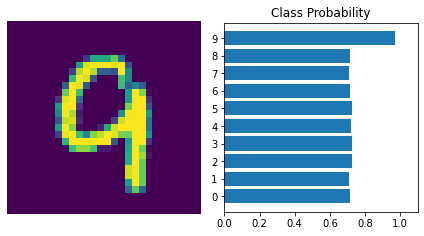

In [ ]:
images, labels = next(iter(valloader))
#images, labels = images.to(device), labels.to(device)

#img = 0.0357*images[0].view(1, 784)
img = ball.projx(images[0].view(1, 784))
img_gpu = img.to(device)
with torch.no_grad():
    out = model(img_gpu)

ps = out.cpu()
print(ps)
probab = list(ps.numpy()[0])
print(probab)
print("Predicted Digit =", probab.index(max(probab)))
helper.view_classify(img.view(1, 28, 28), ps)

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  images, labels = images.to(device), labels.to(device)
  for i in range(len(labels)):
    #img = 0.0357*images[i].view(1, 784)
    img = ball.projx(images[i].view(1, 784))
    with torch.no_grad():
        out = model(img)

    
    ps = out.cpu()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9743


Current status of experiments:
1. Using just Hyperboic Linear modules, and with the appropriate self-tuned hyperparameters, and a batch size of 512, the average accuracy was around 90 percent
2. With the use of activation functions(ReLu, ReLu, then LogSoftMax at the output layer), (by applying the functions in the tangent space, then mapping it back to the hyperbolic space), we see an increase in the model accuracy to about 97-98 percent.
3. To account for the correct class probabilities , linear layer was used as the output layer instead, together with the crossentropy loss function.